In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import (models, transforms)
import os
import utils
from pathlib import Path
import trainer
from torchinfo import summary
import time
import matplotlib.pyplot as plt
import numpy as np
import simplify
import torch.nn.utils.prune as prune

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [16]:
vit_default = utils.load_default_model()
loss_fn = nn.CrossEntropyLoss()
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
pretrained_vit_transforms = pretrained_vit_weights.transforms()

In [17]:
prunning = 0.2
pruned_model = utils.prune_vit(vit_default, prunning)
pruned_model.load_state_dict(torch.load(f"model/Pruning/ViT-PrunningDef{prunning:.2f}-Best.pht", weights_only=True))
pruned_model.to(torch.bfloat16)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=2458, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=2458, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [18]:
_, _, val_dl, _ = utils.create_loaders("data", transform=pretrained_vit_transforms, batch_size=1, dtype=torch.bfloat16)
loss_fn = nn.CrossEntropyLoss()

In [19]:
for parameter in pruned_model.parameters():
    parameter.requires_grad = False

In [20]:
#trainer.evaluate(pruned_model, val_dl, loss_fn, device)

Doing warm-up runs...
Ended warm-up, beginning true runs...


100%|██████████| 100/100 [00:34<00:00,  2.86it/s]


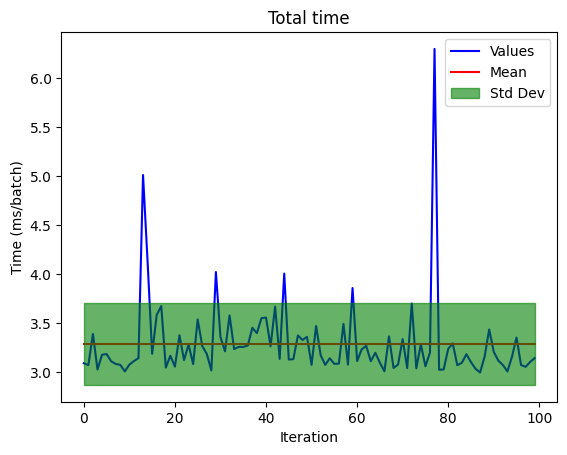

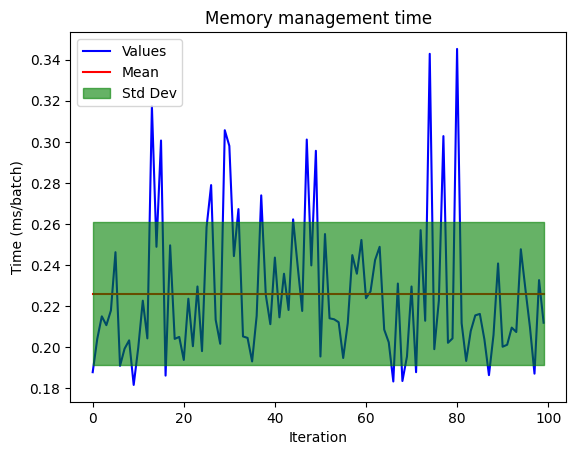

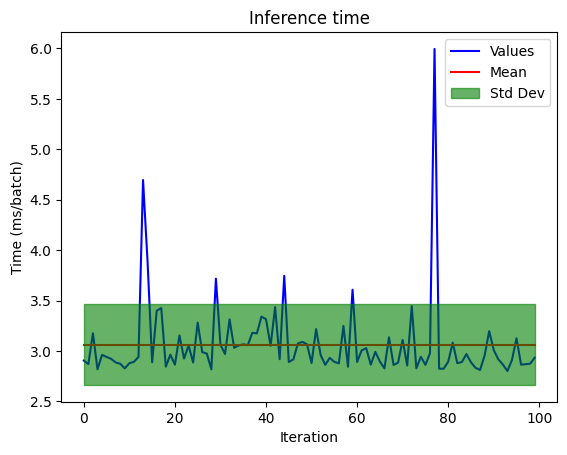

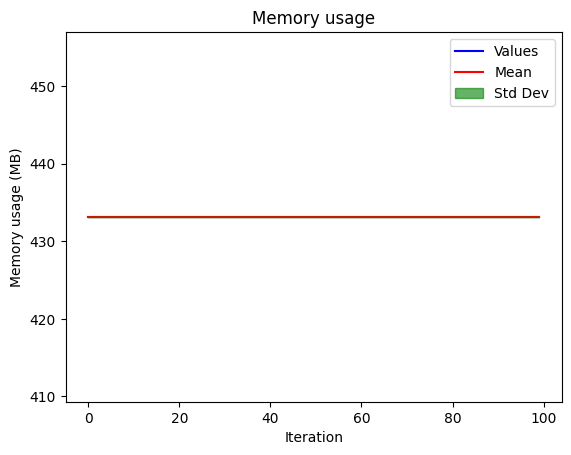

Mean total time over 100 executions: 3.2899832725524902 ms/batch 
Mean memory time over 100 executions: 0.22608280181884766 ms/batch 
Mean inference time over 100 executions: 3.0639004707336426 ms/batch 
Mean memory over 100 executions: 433.142578125 MB


In [21]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
metrics = trainer.getMetrics(pruned_model, val_dl, device, num_times=100, save_plots=True, model_title=f'ViT-Prunning-{round(prunning*100)}')